In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale
import random
import cv2
from imgaug import augmenters as iaa
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation

In [ ]:
training_images = "/content/drive/My Drive/leaf/pattern/train_images/"

In [ ]:
data = pd.read_csv("/content/drive/My Drive/pattern/leafdisease.csv")
data["filepath"] = training_images+data["image_id"]

In [ ]:
data

,image_id,label,filepath
0,1000015157.jpg,0,/content/drive/My Drive/leaf/pattern/train_ima...
1,1000201771.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
2,100042118.jpg,1,/content/drive/My Drive/leaf/pattern/train_ima...
3,1000723321.jpg,1,/content/drive/My Drive/leaf/pattern/train_ima...
4,1000812911.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
...,...,...,...
995,1172047582.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
996,1172185263.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
997,1172216777.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
998,117226420.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...


In [ ]:
data.head()

,image_id,label,filepath
0,1000015157.jpg,0,/content/drive/My Drive/leaf/pattern/train_ima...
1,1000201771.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
2,100042118.jpg,1,/content/drive/My Drive/leaf/pattern/train_ima...
3,1000723321.jpg,1,/content/drive/My Drive/leaf/pattern/train_ima...
4,1000812911.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...


In [ ]:
data.tail()

,image_id,label,filepath
995,1172047582.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
996,1172185263.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
997,1172216777.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
998,117226420.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
999,1172621803.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...


In [ ]:
data.shape

(1000, 3)

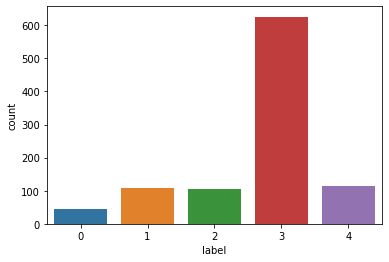

In [ ]:
sns.countplot(data['label'])

In [ ]:
print(data["label"].value_counts())

3    626
4    113
1    109
2    106
0     46
Name: label, dtype: int64


In [ ]:
names_of_disease = pd.read_json('/content/drive/MyDrive/pattern/label_num_to_disease_map.json', typ='series')
names_of_disease

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy
dtype: object

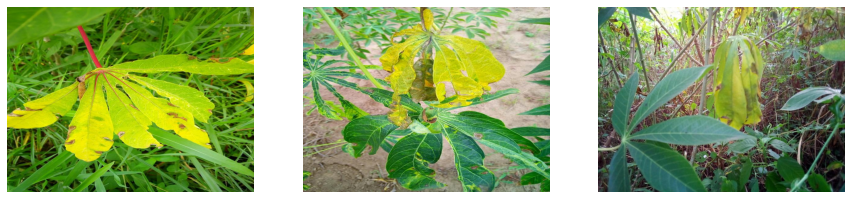

In [ ]:
CBB = data[data.label == 0].sample(3)
plt.figure(figsize=(15, 5))
for i, (image_id, label) in enumerate(zip(CBB.image_id, CBB.label)):
    plt.subplot(1, 3, i + 1)
    img = cv2.imread(os.path.join(training_images, image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
plt.show()

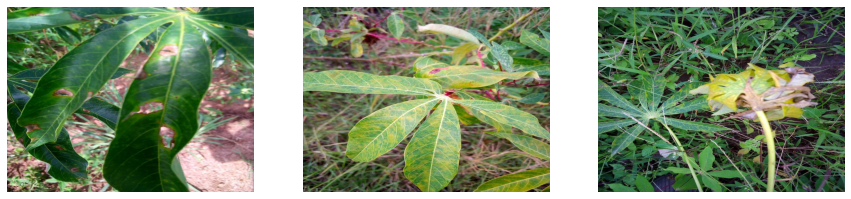

In [16]:
CBSD = data[data.label == 1].sample(3)
plt.figure(figsize=(15, 5))
for i, (image_id, label) in enumerate(zip(CBSD.image_id, CBSD.label)):
    plt.subplot(1, 3, i + 1)
    img = cv2.imread(os.path.join(training_images, image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
plt.show()

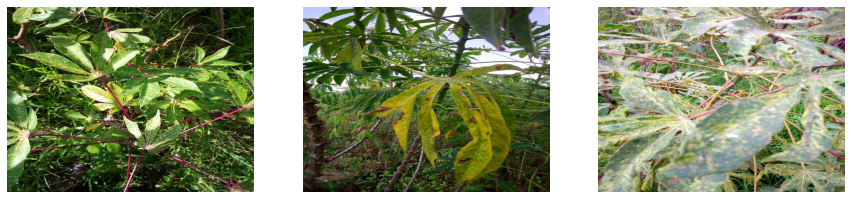

In [17]:
CGM = data[data.label == 2].sample(3)
plt.figure(figsize=(15, 5))
for i, (image_id, label) in enumerate(zip(CGM.image_id, CGM.label)):
    plt.subplot(1, 3, i + 1)
    img = cv2.imread(os.path.join(training_images, image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

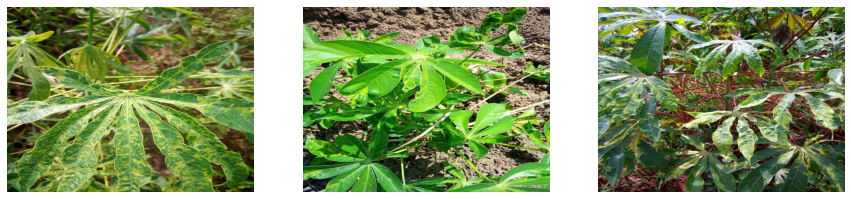

In [18]:
CMD = data[data.label == 3].sample(3)
plt.figure(figsize=(15, 5))
for i, (image_id, label) in enumerate(zip(CMD.image_id, CMD.label)):
    plt.subplot(1, 3, i + 1)
    img = cv2.imread(os.path.join(training_images, image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
plt.show()

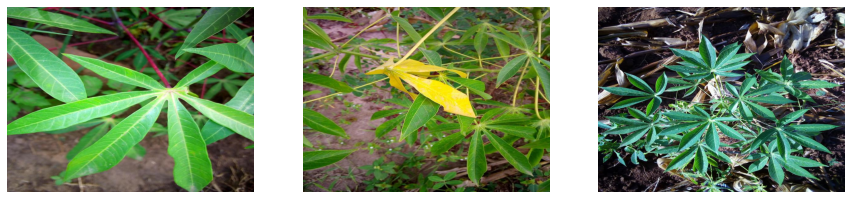

In [19]:
Healthy = data[data.label == 4].sample(3)
plt.figure(figsize=(15, 5))
for i, (image_id, label) in enumerate(zip(Healthy.image_id, Healthy.label)):
    plt.subplot(1, 3, i + 1)
    img = cv2.imread(os.path.join(training_images, image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
plt.show()

In [20]:
training_percentage = 0.8
training_item_count = int(len(data)*training_percentage)
training_item_count

800

In [21]:
validation_item_count = len(data)-int(len(data)*training_percentage)
validation_item_count

200

In [22]:
training_df = data[:training_item_count]
training_df

,image_id,label,filepath
0,1000015157.jpg,0,/content/drive/My Drive/leaf/pattern/train_ima...
1,1000201771.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
2,100042118.jpg,1,/content/drive/My Drive/leaf/pattern/train_ima...
3,1000723321.jpg,1,/content/drive/My Drive/leaf/pattern/train_ima...
4,1000812911.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
...,...,...,...
795,1136287930.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
796,1136746572.jpg,1,/content/drive/My Drive/leaf/pattern/train_ima...
797,1136801202.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
798,1136820675.jpg,1,/content/drive/My Drive/leaf/pattern/train_ima...


In [23]:
validation_df = data[training_item_count:]
validation_df

,image_id,label,filepath
800,1137391278.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
801,1137421218.jpg,1,/content/drive/My Drive/leaf/pattern/train_ima...
802,1137454058.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
803,1137468272.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
804,1137518834.jpg,1,/content/drive/My Drive/leaf/pattern/train_ima...
...,...,...,...
995,1172047582.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
996,1172185263.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
997,1172216777.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...
998,117226420.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...


In [24]:
batch_size = 8
image_size = 512
dropout_rate = 0.4
input_shape = (image_size, image_size, 3)
input_shape

(512, 512, 3)

In [25]:
classes_to_predict = sorted(training_df.label.unique())
classes_to_predict

[0, 1, 2, 3, 4]

In [26]:
training_data = tf.data.Dataset.from_tensor_slices((training_df.filepath.values, training_df.label.values))

In [27]:
for element in training_data:
  print(element)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/My Drive/leaf/pattern/train_images/1000015157.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/My Drive/leaf/pattern/train_images/1000201771.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/My Drive/leaf/pattern/train_images/100042118.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/My Drive/leaf/pattern/train_images/1000723321.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/My Drive/leaf/pattern/train_images/1000812911.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/My Drive/leaf/pattern/train_images/1000837476.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content

In [28]:
validation_data = tf.data.Dataset.from_tensor_slices((validation_df.filepath.values, validation_df.label.values))

In [29]:
for element in validation_data:
  print(element)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/My Drive/leaf/pattern/train_images/1137391278.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/My Drive/leaf/pattern/train_images/1137421218.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/My Drive/leaf/pattern/train_images/1137454058.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/My Drive/leaf/pattern/train_images/1137468272.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/My Drive/leaf/pattern/train_images/1137518834.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/My Drive/leaf/pattern/train_images/1137582859.jpg'>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/conten

In [30]:
def load_image_and_label_from_path(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

training_data = training_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)


training_data_batches = training_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
validation_data_batches = validation_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [31]:
adapt_data = tf.data.Dataset.from_tensor_slices(training_df.filepath.values)


In [32]:
for element in adapt_data:
  print(element)

tf.Tensor(b'/content/drive/My Drive/leaf/pattern/train_images/1000015157.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/My Drive/leaf/pattern/train_images/1000201771.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/My Drive/leaf/pattern/train_images/100042118.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/My Drive/leaf/pattern/train_images/1000723321.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/My Drive/leaf/pattern/train_images/1000812911.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/My Drive/leaf/pattern/train_images/1000837476.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/My Drive/leaf/pattern/train_images/1000910826.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/My Drive/leaf/pattern/train_images/1001320321.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/My Drive/leaf/pattern/train_images/1001723730.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/My Drive/leaf/pattern/train_images/1001742395.j

In [33]:
def adapt_mode(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = layers.experimental.preprocessing.Rescaling(1.0 / 255)(img)
    return img

adapt_data = adapt_data.map(adapt_mode, num_parallel_calls=AUTOTUNE)
adapt_data_batches = adapt_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [34]:
adapt_mode('/content/drive/My Drive/leaf/pattern/train_images/1137270192.jpg')

<tf.Tensor: shape=(600, 800, 3), dtype=float32, numpy=
array([[[0.1764706 , 0.19607845, 0.21176472],
        [0.17254902, 0.19215688, 0.20392159],
        [0.16470589, 0.18823531, 0.18823531],
        ...,
        [0.09019608, 0.11764707, 0.09019608],
        [0.08627451, 0.1137255 , 0.08627451],
        [0.08627451, 0.1137255 , 0.08627451]],

       [[0.18823531, 0.20784315, 0.22352943],
        [0.18823531, 0.20784315, 0.21960786],
        [0.19215688, 0.21568629, 0.21568629],
        ...,
        [0.09803922, 0.1254902 , 0.09803922],
        [0.09019608, 0.11764707, 0.09019608],
        [0.08627451, 0.1137255 , 0.08627451]],

       [[0.16862746, 0.20000002, 0.20784315],
        [0.1764706 , 0.20784315, 0.21568629],
        [0.18431373, 0.21960786, 0.21568629],
        ...,
        [0.10980393, 0.14901961, 0.1137255 ],
        [0.09803922, 0.13725491, 0.10196079],
        [0.09019608, 0.12941177, 0.09411766]],

       ...,

       [[0.01568628, 0.04705883, 0.05490196],
        [0.01

In [35]:
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomCrop(height=image_size, width=image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.25),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

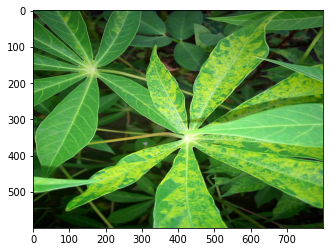

In [36]:
image = Image.open("/content/drive/My Drive/pattern/train_images/1041184552.jpg")
plt.imshow(image)
plt.show()

In [37]:
image = tf.expand_dims(np.array(image), 0)

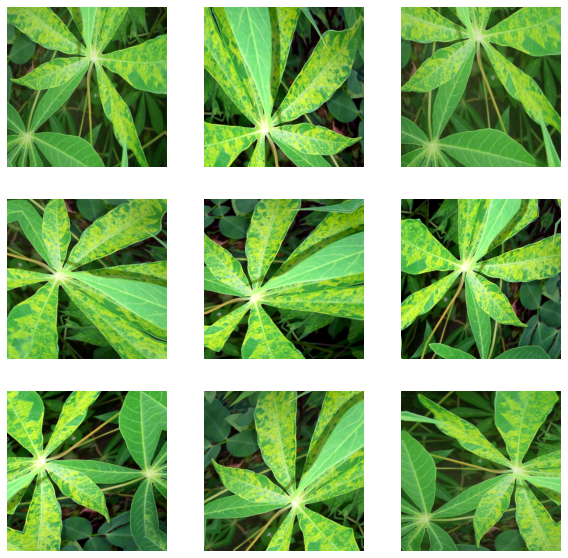

In [38]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation_layers(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [39]:
efficientnet = EfficientNetB3(weights="/content/drive/My Drive/pattern/efficientnet/efficientnetb3_notop.h5", 
                              include_top=False, 
                              input_shape=input_shape, 
                              drop_connect_rate=dropout_rate)

inputs = Input(shape=input_shape)
augmented = data_augmentation_layers(inputs)
efficientnet = efficientnet(augmented)
pooling = layers.GlobalAveragePooling2D()(efficientnet)
dropout = layers.Dropout(dropout_rate)(pooling)
outputs = Dense(len(classes_to_predict), activation="softmax")(dropout)
model = Model(inputs=inputs, outputs=outputs)
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 16, 16, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
____________________________________________

In [40]:
epochs = 10

In [41]:
decay_steps = int(round(len(training_df)/batch_size))*epochs
decay_steps

1000

In [42]:
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

In [43]:
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [44]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), metrics=["accuracy"])

In [45]:
history = model.fit(training_data_batches,
                  epochs = epochs, 
                  validation_data=validation_data_batches,
                  callbacks=callbacks)

Epoch 1/10
100/100 [==============================] - 2458s 24s/step - loss: 1.3368 - accuracy: 0.4714 - val_loss: 0.7749 - val_accuracy: 0.7500
Epoch 2/10
100/100 [==============================] - 2357s 24s/step - loss: 0.8509 - accuracy: 0.6997 - val_loss: 0.5233 - val_accuracy: 0.7900
Epoch 3/10
100/100 [==============================] - 2337s 23s/step - loss: 0.7238 - accuracy: 0.7397 - val_loss: 0.4812 - val_accuracy: 0.8550
Epoch 4/10
100/100 [==============================] - 2353s 24s/step - loss: 0.5883 - accuracy: 0.7976 - val_loss: 0.4000 - val_accuracy: 0.8550
Epoch 5/10
100/100 [==============================] - 2356s 24s/step - loss: 0.5177 - accuracy: 0.8145 - val_loss: 0.3980 - val_accuracy: 0.8600
Epoch 6/10
100/100 [==============================] - 2377s 24s/step - loss: 0.4389 - accuracy: 0.8420 - val_loss: 0.3642 - val_accuracy: 0.8650
Epoch 7/10
100/100 [==============================] - 2375s 24s/step - loss: 0.4473 - accuracy: 0.8372 - val_loss: 0.3659 - val_ac

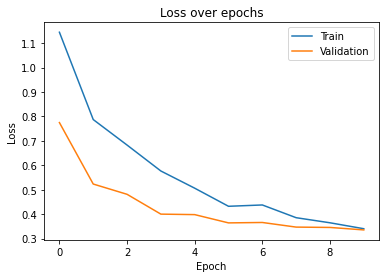

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

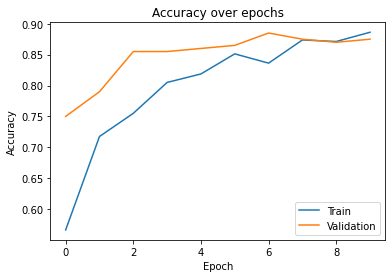

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [48]:
model.load_weights("./best_model.h5")

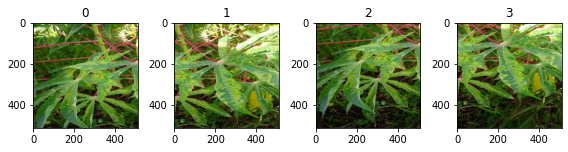

In [49]:
def scan_over_image(img_path, crop_size=512):  
    img = Image.open(img_path)
    img_height, img_width = img.size
    img = np.array(img)
    
    y = random.randint(0,img_height-crop_size)
    x = random.randint(0,img_width-crop_size)

    x_img_origins = [0,img_width-crop_size]
    y_img_origins = [0,img_height-crop_size]
    img_list = []
    for x in x_img_origins:
        for y in y_img_origins:
            img_list.append(img[x:x+crop_size , y:y+crop_size,:])
  
    return np.array(img_list)

def display_samples(img_path):
    img_list = scan_over_image(img_path)
    sample_number = len(img_list)
    fig = plt.figure(figsize = (8,sample_number))
    for i in range(0,sample_number):
        ax = fig.add_subplot(2, 4, i+1)
        ax.imshow(img_list[i])
        ax.set_title(str(i))
    plt.tight_layout()
    plt.show()

display_samples("/content/drive/My Drive/pattern/train_images/3412658650.jpg")

test_time_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

In [50]:
def predict_and_vote(image_filename, folder, TTA_runs=4):
    localised_predictions = []
    local_image_list = scan_over_image(folder+image_filename)
    for local_image in local_image_list:
        duplicated_local_image = tf.convert_to_tensor(np.array([local_image for i in range(TTA_runs)]))
        augmented_images = test_time_augmentation_layers(duplicated_local_image)
        predictions = model.predict(augmented_images)
        localised_predictions.append(np.sum(predictions, axis=0))
    global_predictions = np.sum(np.array(localised_predictions),axis=0)
    final_prediction = np.argmax(global_predictions)   
    return final_prediction

In [51]:
def run_predictions_over_image_list(image_list, folder):
    predictions = []
    with tqdm(total=len(image_list)) as pbar:
        for image_filename in image_list:
            pbar.update(1)
            predictions.append(predict_and_vote(image_filename, folder))
    return predictions

In [52]:
validation_df["results"] = run_predictions_over_image_list(validation_df["image_id"], training_images)

100%|██████████| 200/200 [36:59<00:00, 11.10s/it]


In [53]:
!cat /content/drive/MyDrive/pattern/label_num_to_disease_map.json

{"0": "Cassava Bacterial Blight (CBB)", "1": "Cassava Brown Streak Disease (CBSD)", "2": "Cassava Green Mottle (CGM)", "3": "Cassava Mosaic Disease (CMD)", "4": "Healthy"}


In [54]:
validation_df[:20]

,image_id,label,filepath,results
800,1137391278.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...,3
801,1137421218.jpg,1,/content/drive/My Drive/leaf/pattern/train_ima...,1
802,1137454058.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...,3
803,1137468272.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...,3
804,1137518834.jpg,1,/content/drive/My Drive/leaf/pattern/train_ima...,1
805,1137582859.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...,3
806,1137631673.jpg,1,/content/drive/My Drive/leaf/pattern/train_ima...,3
807,1137739472.jpg,2,/content/drive/My Drive/leaf/pattern/train_ima...,2
808,1138006821.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...,3
809,113803368.jpg,3,/content/drive/My Drive/leaf/pattern/train_ima...,3


In [55]:
true_positives = 0
prediction_distribution_per_class = {"0":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "1":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "2":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "3":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "4":{"0": 0, "1": 0, "2":0, "3":0, "4":0}}
number_of_images = len(validation_df)
for idx, pred in validation_df.iterrows():
    if int(pred["label"]) == pred.results:
        true_positives+=1
    prediction_distribution_per_class[str(pred["label"])][str(pred.results)] += 1
print("Accuracy: {}%".format(true_positives/number_of_images*100))

Accuracy: 86.0%


In [56]:
prediction_distribution_per_class

{'0': {'0': 3, '1': 0, '2': 0, '3': 0, '4': 2},
 '1': {'0': 3, '1': 14, '2': 1, '3': 1, '4': 3},
 '2': {'0': 1, '1': 1, '2': 9, '3': 4, '4': 1},
 '3': {'0': 0, '1': 1, '2': 3, '3': 129, '4': 2},
 '4': {'0': 2, '1': 1, '2': 1, '3': 1, '4': 17}}

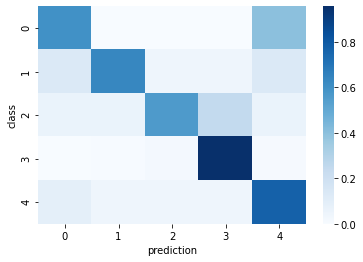

In [58]:
heatmap_df = pd.DataFrame(columns={"class","prediction","value"})
for key in prediction_distribution_per_class.keys():
    for pred_key in prediction_distribution_per_class[key].keys():
        value = prediction_distribution_per_class[key][pred_key]/validation_df.query("label==@key").count()[0]
        heatmap_df = heatmap_df.append({"class":key,"prediction":pred_key,"value":value}, ignore_index=True)   

heatmap = heatmap_df.pivot(index='class', columns='prediction', values='value')
sns.heatmap(heatmap,cmap="Blues")

In [59]:
test_folder = '/content/drive/My Drive/pattern/test_images/'
predict_df = pd.DataFrame(columns={"image_id","label"})
predict_df["image_id"] =  os.listdir(test_folder)
predict_df["label"] = 0

In [60]:
predict_df["label"] = run_predictions_over_image_list(predict_df["image_id"], test_folder)

100%|██████████| 20/20 [03:47<00:00, 11.40s/it]


In [61]:
predict_df

,label,image_id
0,4,2216849948.jpg
1,4,4293817306.jpg
2,3,4293661491.jpg
3,0,4293589004.jpg
4,3,469514672.jpg
5,3,470266437.jpg
6,3,471126071.jpg
7,3,471647021.jpg
8,3,469798275.jpg
9,3,469651575.jpg
